# Fruit and Vegetable Classification
## \# Class activation heatmap for image classification
Taken from: https://www.kaggle.com/code/databeru/fruit-and-vegetable-classification

## \# Grad-CAM class activation visualization

Having 3861 images of 36 different fruits/vegetables

![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MichaelTay/w281-summer-2023-project/blob/main/feature_detection.ipynb)

<h1>Table of contents</h1>


<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present


In [198]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [199]:
import os

# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#mountdir = '/content/drive'
#drive.mount(mountdir, force_remount=True)

#localdir = mountdir + '/MyDrive'
# Replace your folder here
#w281_directory = '/Berkeley/w281/Fruit-and-Vegetable-Classification/'
#inputdir = localdir + w281_directory
# Uncomment below if using local folder
inputdir = ""

In [200]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import cv2
#import tensorflow as tf

# Create a list with the filepaths for training and testing
train_dir = Path(inputdir, './input/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(inputdir, './input/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(inputdir, './input/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Filter only selected class

In [201]:
# Fruits - banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango.
# Vegetables - Bell Pepper, Cauliflower, Chilli Pepper, Peas, Corn, Spinach, Turnip, Garlic, Ginger, Cabbage
Fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango']
Vegetables = ['bell pepper', 'cauliflower', 'chilli pepper', 'peas', 'corn', 'spinach', 'turnip', 'garlic', 'ginger', 'cabbage']

train_df = train_df[train_df['Label'].isin(Fruits + Vegetables)]
test_df = test_df[test_df['Label'].isin(Fruits + Vegetables)]
val_df = val_df[val_df['Label'].isin(Fruits + Vegetables)]

In [202]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 1540

Number of different labels: 20

Labels: ['banana' 'corn' 'kiwi' 'pear' 'pomegranate' 'watermelon' 'pineapple'
 'ginger' 'bell pepper' 'cauliflower' 'turnip' 'cabbage' 'peas' 'garlic'
 'mango' 'chilli pepper' 'spinach' 'grapes' 'orange' 'apple']


In [203]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
4,input/train/banana/Image_1.jpg,banana
5,input/train/corn/Image_48.jpg,corn
6,input/train/kiwi/Image_35.jpg,kiwi
7,input/train/pear/Image_72.jpg,pear
8,input/train/pomegranate/Image_32.jpg,pomegranate


# Show a sample of the image

banana
(800, 1200, 3)


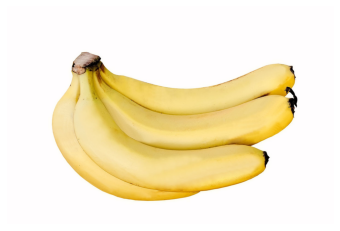

In [204]:
for index, row in train_df.iterrows():
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)
  plt.axis("off")
  plt.imshow(img)
  print(label)
  print(img.shape)
  break

## Edge Detection

In [205]:
def find_edges(img0):

  # converting to gray scale
  gray = cv2.cvtColor(np.float32(img0), cv2.COLOR_BGR2GRAY)
  #color = cv2.cvtColor(np.float32(img0), cv2.COLOR_BGRA2RGB)

  # remove noise
  img = cv2.GaussianBlur(gray,(3,3),0)

  # convolve with proper kernels
  laplacian = cv2.Laplacian(img,cv2.CV_32F)
  sobelx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=5)  # x
  sobely = cv2.Sobel(img,cv2.CV_32F,0,1,ksize=5)  # y

  return laplacian, sobelx, sobely

def plot_edges(img, laplacian, sobelx, sobely):
  plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
  plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
  plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
  plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

  plt.show()
  return

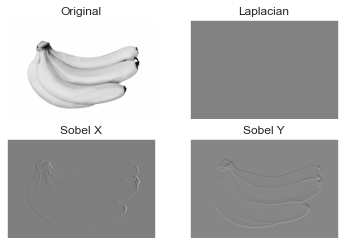

In [206]:
for index, row in train_df.iterrows():
  filepath = row['Filepath']
  label = row['Label']

  # loading image
  img0 = cv2.imread(filepath)

  # converting to gray scale
  gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

  # remove noise
  img = cv2.GaussianBlur(gray,(3,3),0)

  # convolve with proper kernels
  laplacian = cv2.Laplacian(img,cv2.CV_64F)
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  # x
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  # y

  plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
  plt.title('Original'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
  plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
  plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
  plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
  plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

  plt.show()
  break

## Generate Sample Images of Edges

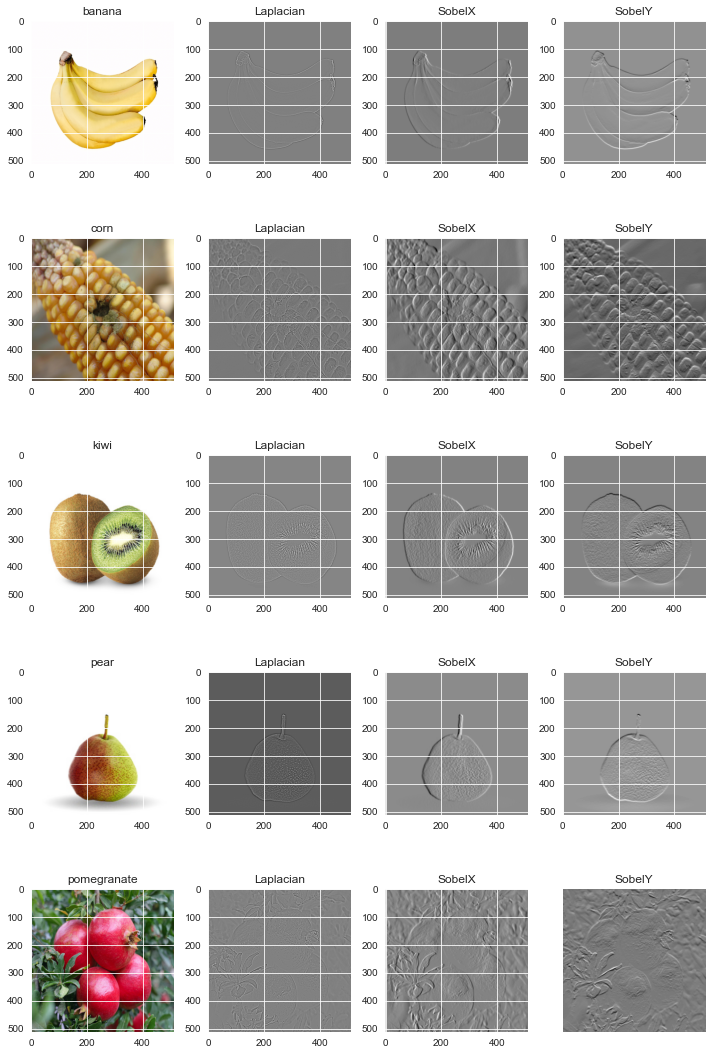

In [207]:
#img_dim = 256
img_dim = 512

unique_df = train_df.drop_duplicates(['Label'])
num_examples = min(5, len(unique_df))
n_rows = num_examples
n_cols = 4
f, axarr = plt.subplots(n_rows, n_cols, figsize=(10, 16))

for index, item in enumerate(unique_df.iterrows()):
  if index >= n_rows:
    break
  row = item[1]
  filepath = row['Filepath']
  label = row['Label']

  # reading the image
  img = imread(filepath)
  resized_img = resize(img, (img_dim, img_dim), anti_aliasing=True)

  #creating edge features
  laplacian, sobelx, sobely = find_edges(resized_img)

  if (n_rows == 1):
    axarr[index, 0].set_title(f"{label}")
    axarr[0].imshow(resized_img, cmap='gray')
    axarr[index, 1].set_title("Laplacian")
    axarr[1].imshow(laplacian, cmap='gray')
    axarr[index, 2].set_title("SobelX")
    axarr[2].imshow(sobelx, cmap='gray')
    axarr[index, 3].set_title("SobelY")
    axarr[3].imshow(sobely, cmap='gray')
  else:
    axarr[index, 0].set_title(f"{label}")
    axarr[index, 0].imshow(resized_img, cmap='gray')
    axarr[index, 1].set_title("Laplacian")
    axarr[index, 1].imshow(laplacian, cmap='gray')
    axarr[index, 2].set_title("SobelX")
    axarr[index, 2].imshow(sobelx, cmap='gray')
    axarr[index, 3].set_title("SobelY")
    axarr[index, 3].imshow(sobely, cmap='gray')


  plt.axis("off")
  plt.tight_layout()